## Imports

In [2]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

from DS_2_2024_HW2_efficient_net import EfficientNet

In [3]:
tf.keras.utils.set_random_seed(16)

## Data

In [4]:
# Height, width and number of channels
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example

In [5]:
# Load data. Train & Dev datasets are stored as tfrecord objects (see https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)-
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord")
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord")

# Process data. Train & Dev are decoded from jpeg; Test data are constructed from list.
train = train.map(parse)
dev = dev.map(parse)

num_observations_train = sum(1 for _ in train)
print(num_observations_train)

num_observations_dev = sum(1 for _ in dev)
print(num_observations_dev)

2142
306


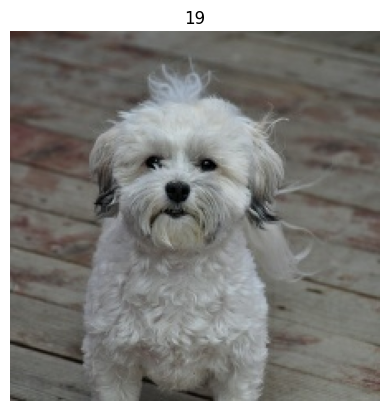

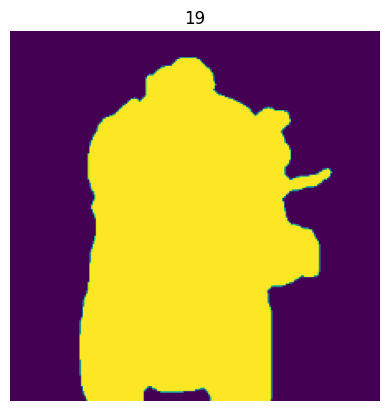

In [6]:
plt.imshow(next(iter(train.skip(0)))["image"])
plt.axis('off')  # Turn off axis
plt.title(int(next(iter(train.skip(0)))["label"]))
plt.show()

plt.imshow(next(iter(train.skip(0)))["mask"])
plt.axis('off')  # Turn off axis
plt.title(int(next(iter(train.skip(0)))["label"]))
plt.show()

#plt.imshow(next(iter(train.skip(0)))["mask"])
#plt.axis('off')  # Turn off axis
#plt.show()

# Build Model

Continue by initializing EfficientNet, building the model, augmentation and training.

In [7]:
# Call constructor of EfficientNet and call your object 'base_model'. You need to specify several parameters:
# - width_coefficient, depth_coefficient: determine the scale for depth and width of the network. Reasonable to start with both equal to 1.0
# - default_resolution: resolution of an input image
# - dropout_rate: dropout rate used throughout the network
# - include_top: if True then the network will include the final classification layer and produce a prediction for 1000 classes in ImageNet classification dataset,
# if False, the network will return 'image features' (the result of the last global average pooling)
# weights: path to the file for pre-trained weights. Use 'efficientnet.h5' that you have downloaded from the Kaggle competition

base_model = EfficientNet(
    width_coefficient = 1,
    depth_coefficient = 1,
    default_resolution = 224,
    weights = "efficientnet.h5",
    include_top = False
)

In [8]:
# Calling constuctor of EfficientNet you have constructed a tf.keras.Model object. 
# Iterate over layers of that model and set their attribute 'trainable' to False for most of them,
# (in this way you will train only some of the large number of parameters; - is it reasonable to train the first or the last layers?)
# Use method .summary() to investigate the number of trainable and non-trainable parameters

#base_model.summary() # originally over 5 million (4 million after taking only average pooling at the end) trainable parameters
#len(base_model.layers) # 223 layers

for layer in base_model.layers[:150]:
   layer.trainable = False

#base_model.summary()

In [9]:
# Use API logic seen on the practicals to build the following model:
# The input layer takes images with 3 channels and passes them to the initialized EfficientNet model
# After processing through EfficientNet model, add few more fully connected layers, with regularization of your choice
# Output of your model should be a vector of probabilities for each of the breed.

reg = tf.keras.regularizers.L1L2(l2=0.001)

# Input:
inputs = tf.keras.layers.Input([H, W, C])

# Hidden Layers:
x = base_model(inputs)[0]

# Outputs:
outputs = tf.keras.layers.Dense(LABELS, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet (Functional)   [(None, 1280),            4049564   
                              (None, 7, 7, 1280),                
                              (None, 14, 14, 112),               
                              (None, 28, 28, 40),                
                              (None, 56, 56, 24),                
                              (None, 112, 112, 16)]              
                                                                 
 dense (Dense)               (None, 34)                43554     
                                                                 
Total params: 4,093,118
Trainable params: 3,294,270
Non-trainable params: 798,848
_____________________________________________

In [15]:
# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [13]:
# We define pipeline that will consist of augmentation, label smoothing and batching

def augment_train(input):
    image = input['image']
    label = input['label']
    
    # Augmentation procedures (modify to your wish)

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#        tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
#        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1),
#        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
#    image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])

    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']
    
    # Augmentation procedures (add to your wish)
    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#    image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])
    # Note: if we add augmentation also to dev dataset, we can assume that
    # performance of test dataset will be better as test dataset is not augmented
    
    return image, label

# Label smoothing

def label_smooth_train(image, labels, alpha, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    labels *= (1 - alpha)
    labels += alpha / n_labels
    return image, labels

def label_smooth_dev(image, labels, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    return image, labels

# Now we apply augmentation using .map()
train = train.map(augment_train)
dev = dev.map(augment_dev)

# Label smoothing
train = train.map(lambda x, y: label_smooth_train(x, y, 0.05, LABELS))
dev = dev.map(lambda x, y: label_smooth_dev(x, y, LABELS))

# Apply .batch() to 'train' and 'dev' with some choice of batch size => choosing batch size 34, we have 2142/34 = 63 batches in train and 9 in dev in one epoch
train = train.batch(34)
dev = dev.batch(34)

In [16]:
# Fit your model using early stopping
epochs = 6

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/HW2')

model.fit(train,
          epochs=epochs,
          validation_data=dev,
          callbacks=[early_call])

Epoch 1/6
63/63 [==============================] - 131s 2s/step - loss: 1.8397 - categorical_accuracy: 0.5458 - val_loss: 0.9156 - val_categorical_accuracy: 0.7092
Epoch 2/6
63/63 [==============================] - 119s 2s/step - loss: 0.7717 - categorical_accuracy: 0.8828 - val_loss: 0.7824 - val_categorical_accuracy: 0.7712
Epoch 3/6
63/63 [==============================] - 116s 2s/step - loss: 0.5335 - categorical_accuracy: 0.9767 - val_loss: 0.7082 - val_categorical_accuracy: 0.7974
Epoch 4/6
16/63 [======>.......................] - ETA: 1:20 - loss: 0.4746 - categorical_accuracy: 0.9908

KeyboardInterrupt: 

# Evaluate

Load test dataset, predict labels and store results. Note that (for educational purposes) we load the data from pickled list. Therefore, transformation to Tensorflow dataset has to be done.

In [13]:
# Load test dataset stored as pickled list.
with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)
num_observations_test = sum(1 for _ in test)
print(num_observations_test)


# Apply batching also to 'test'
test = test.batch(30)

# Predict
test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

# Store results
pd.DataFrame({'prediction': test_prediction}).to_csv('hw2_outofsample_prediction.csv', index=True, header=True)

150
